# Support Vector Machines

<h1>Índice<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hard-margin-classifier" data-toc-modified-id="Hard-margin-classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hard margin classifier</a></span></li><li><span><a href="#Soft-margin-classfier" data-toc-modified-id="Soft-margin-classfier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Soft margin classfier</a></span></li></ul></div>

Primero, corremos la celda de preparación.

In [250]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "07_Clasificación"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [251]:
# Definamos una función práctica
def plot_clasi(x, t, ws, labels=[], xp=[-1., 1.], thr=[0,], spines='zero', equal=True):
    """
    Figura con el resultado del ajuste lineal
    """
    assert len(labels) == len(ws) or len(labels) == 0
    assert len(ws) == len(thr)
    
    if len(labels) == 0:
        labels = np.arange(len(ws)).astype('str')
    
    # Agregemos el vector al plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    xc1 = x[:, t[0] == 1]
    xc2 = x[:, t[0] == -1]
    
    ax.plot(*xc1, 'ob', mfc='None', label='C1')
    ax.plot(*xc2, 'or', mfc='None', label='C2')

    for i, w in enumerate(ws):
        
        # Ploteo vector de pesos
        x0 = 0.5 * (xp[0] + xp[1])
        ax.quiver(0, thr[i]/w[1], w[0], w[1], color='C{}'.format(i+2), scale=10, label=labels[i],
                 zorder=10)

        # ploteo plano perpendicular
        xp = np.array(xp)
        yp = (thr[i] -w[0]*xp)/w[1] 

        plt.plot(xp, yp, '-', color='C{}'.format(i+2))
        
    # Ploteo línea que une centros de los conjuntos
    mu1 = xc1.mean(axis=1)
    mu2 = xc2.mean(axis=1)
    ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)

#     ax.set_xlabel('$x_1$')
#     ax.set_ylabel('$x_2$')
    ax.legend(loc=0, fontsize=12)
    if equal:
        ax.set_aspect('equal')
    
    if spines is not None:
        for a in ['left', 'bottom']:
            ax.spines[a].set_position('zero')
        for a in ['top', 'right']:
            ax.spines[a].set_visible(False)
        
#     ax.set_xlim(-7, 3)
#     ax.set_ylim(-4, 4)
    return

## Hard margin classifier

$\newcommand{\vv}[1]{\boldsymbol{#1}}$
$\newcommand{\om}[0]{\boldsymbol{\omega}}$
$\newcommand{\norm}[0]{\mathcal{N}}$
$\newcommand{\b}[1]{\mathrm{\mathbf{#1}}}$
$\newcommand{\T}{^\mathrm{T}}$
$\newcommand{\cu}{\mathcal{C}_1}$
$\newcommand{\cd}{\mathcal{C}_2}$
Cuando vimos clasificación con modelos lineales, encontramos que para problemas linealmente separables, existe una frontera de decisión que genera una clasificación exacta.

Lo que no quedaba claro es que esa frontera fuera la mejor en términos de generalización.

In [252]:
from numpy.random import multivariate_normal

size1 = 250
mu1 = [0, 0]
cov1 = [[1, 0.95],[0.95, 1]]

size2 = 200
mu2 = [-4, 1.5]
cov2 = [[1, 0.8],[0.8, 1]]

np.random.seed(20200922)
# Sample classes
xc1 = multivariate_normal(mean=mu1, cov=cov1, size=size1).T
xc2 = multivariate_normal(mean=mu2, cov=cov2, size=size2).T

print(xc1.shape, xc2.shape)

# Concatenate both classes
x = np.hstack([xc1, xc2])
tc1 = np.ones((1, xc1.shape[1]))
tc2 = -np.ones((1, xc2.shape[1]))
# tc2 = -np.ones((1, xc2.shape[1]))
t = np.hstack([tc1, tc2])

print(x.shape, t.shape)

(2, 250) (2, 200)
(2, 450) (1, 450)


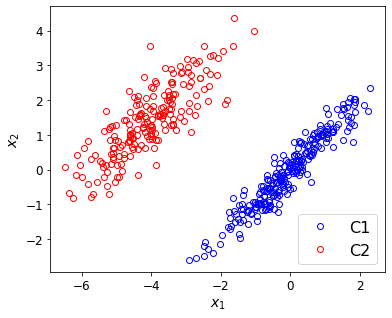

In [253]:
# Veamos cómo se ven
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(*xc1, 'ob', mfc='None', label='C1')
ax.plot(*xc2, 'or', mfc='None', label='C2')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend(loc='lower right', fontsize=16)
ax.set_aspect('equal')

Veamos cómo funciona el perceptrón en este caso.

In [255]:
from sklearn.linear_model import Perceptron

perce = Perceptron(max_iter=1000, fit_intercept=False, warm_start=False)

# En ese caso, la matriz de diseño es simplemente x con una columna de unos
phi0 = np.ones([len(x.T), 1])
phi = np.hstack([phi0, x.T.copy()])

# Pero podríamos probar otras cosas, como esto que está comentado más abajo.
perce = perce.fit(phi, t.flatten())

def makew(fitter):
    
    # # Obtengamos los pesos y normalicemos
    w = fitter.coef_.copy()
    
    # # Incluye intercept
    if fitter.fit_intercept:
        w = np.hstack([fitter.intercept_.reshape(1,1), w])
        
    # # Normalizon
    w /= np.linalg.norm(w)
    return w.T

w_perce = makew(perce)

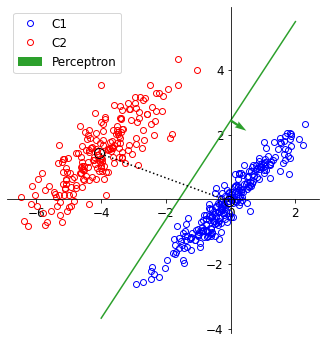

In [256]:
# Comparamos con Fischer
plot_clasi(x, t, [w_perce[1:],], ['Perceptron',], xp=[-4, 2], thr=[-w_perce[0],])

Ok, pero que pasa si le doy otro punto de inicio al perceptrón

[[21.          9.69724574 -7.16178277]]


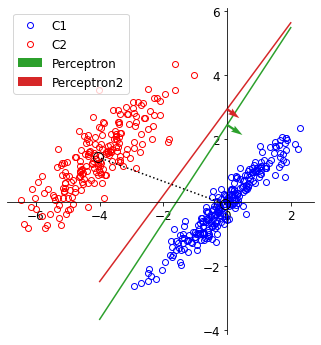

In [257]:
perce2 = Perceptron(max_iter=1000, fit_intercept=False, warm_start=True, random_state=1234)
perce2 = perce2.fit(phi, t.flatten(), coef_init=[1.0, 4.0, 55.0])
w_perce2 = makew(perce2)

print(perce2.coef_)
# print(w_perce2)
# Comparamos con Fischer
plot_clasi(x, t, [w_perce[1:], w_perce2[1:]], ['Perceptron', 'Perceptron2'], xp=[-4, 2], 
           thr=[-w_perce[0], -w_perce2[0]])

In [258]:
perce3 = Perceptron(max_iter=1000, fit_intercept=True, warm_start=True, random_state=1234)
perce3 = perce3.fit(phi[:, 1:], t.flatten(), coef_init=[-34.0, 55.0])

w3 = np.concatenate([perce3.intercept_, perce3.coef_.flatten()])
w3 /= np.sqrt(np.dot(w3.T, w3))

# a = [2, 3, 4]
# b = [1, *a]
# print(b)

# w_perce3 = makew(perce3).T
# print(w3, w_perce2)

# print(w_perce3)
# # Comparamos con Fischer
# plot_clasi(x, t, [w_perce3, w_perce2[1:]], ['Perceptron3', 'Perceptron2'], xp=[-4, 2], 
#            thr=[-perce3.intercept_, -w_perce2[0]])

Podemos preguntarnos cuál de las dos soluciones es mejor. Y por qué...

Una alternativa más robusta es usar clasificadores de margen, como vimos en las diapos recién.

In [259]:
from sklearn.svm import LinearSVC, SVC

# Instancio
svc = LinearSVC(loss='hinge', C=np.infty, fit_intercept=False)

# Matrix de diseño
phi0 = np.ones([len(x.T), 1])
phi = np.hstack([phi0, x.T.copy()])
# phi = x.T.copy()

# Ajusto
svc.fit(phi, t.flatten())

w_hmc = makew(svc)

print(w_hmc)

[[ 0.85008541]
 [ 0.36256833]
 [-0.38196728]]


Podemos encontrar los *support vectors* encontrando los puntos que tienen valor de la función $y(\mathbf{x})<= 1$.

In [260]:
# Find support vectors
isv = np.abs(svc.decision_function(phi)) <= 1.0 + 1e-12

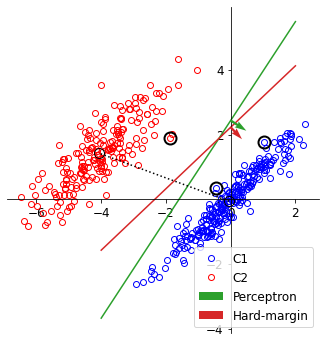

In [261]:
plot_clasi(x, t, [w_perce[1:], w_hmc[1:]], ['Perceptron', 'Hard-margin',], xp=[-4, 2], 
           thr=[-w_perce[0], -w_hmc[0]])

# Plot support vectors
plt.plot(x[0, isv], x[1, isv], 'o', ms=12, mfc='None', mec='k', mew=2)

## Soft margin classfier

Veamos ahora qué pasa si los conjuntos de datos no son linealmente separables. Uso el mismo modelo generativo pero con otros modelos.

In [262]:
from numpy.random import multivariate_normal

size1 = 250
mu1 = [0, 0]
cov1 = [[1, 0.95],[0.95, 1]]

size2 = 250
mu2 = [-1, 1]
#mu2 = [0, 0]
cov2 = [[1, 0.8],[0.8, 1]]

np.random.seed(20200922)
# Sample classes
xc1 = multivariate_normal(mean=mu1, cov=cov1, size=size1).T
xc2 = multivariate_normal(mean=mu2, cov=cov2, size=size2).T

print(xc1.shape, xc2.shape)

# Concatenate both classes
x = np.hstack([xc1, xc2])
tc1 = np.ones((1, xc1.shape[1]))
tc2 = -np.ones((1, xc2.shape[1]))
# tc2 = -np.ones((1, xc2.shape[1]))
t = np.hstack([tc1, tc2])

print(x.shape, t.shape)

(2, 250) (2, 250)
(2, 500) (1, 500)


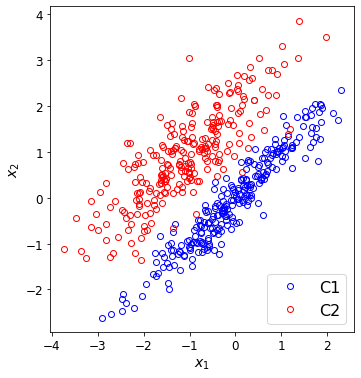

In [263]:
# Veamos cómo se ven
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(*xc1, 'ob', mfc='None', label='C1')
ax.plot(*xc2, 'or', mfc='None', label='C2')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend(loc='lower right', fontsize=16)
ax.set_aspect('equal')

Sadismo algortímico: probemos qué hace el perceptrón.

In [264]:
perce = Perceptron(max_iter=1000, tol=1e-10, fit_intercept=False, warm_start=False)

# En ese caso, la matriz de diseño es simplemente x con una columna de unos
phi0 = np.ones([len(x.T), 1])
phi = np.hstack([phi0, x.T.copy()])

# Pero podríamos probar otras cosas, como esto que está comentado más abajo.
perce = perce.fit(phi, t.flatten())

w_perce = makew(perce)
print(w_perce)

[[ 0.44212713]
 [ 0.62153633]
 [-0.64669637]]


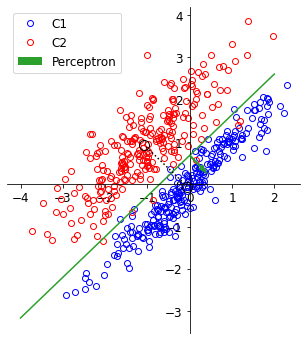

In [265]:
# Veamos cómo le fue
plot_clasi(x, t, [w_perce[1:],], ['Perceptron',], xp=[-4, 2], thr=[-w_perce[0],])

In [266]:
# Instancio
# hmc = LinearSVC(C=np.infty, fit_intercept=True, max_iter=1000)
smc = LinearSVC(C=1.0, fit_intercept=False, max_iter=1000)
# smc = SVC(kernel='linear', degree=1, C=0.005, max_iter=1000)

# Matrix de diseño
phi = np.hstack([phi0, x.T.copy()])
# phi = x.T.copy()

# Ajusto
# hmc.fit(phi, t.flatten())
smc.fit(phi, t.flatten())

# w_hmc = makew(hmc).T
w_smc = makew(smc)

print(w_smc)

[[ 0.47446649]
 [ 0.61531804]
 [-0.62949604]]


In [267]:
isv = np.abs(smc.decision_function(phi)) <= 1

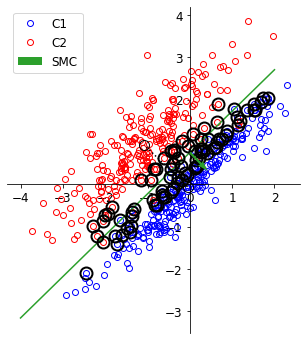

In [268]:
plot_clasi(x, t, [w_smc[1:],], ['SMC', ], xp=[-4, 2], thr=[-w_smc[0],])

plt.plot(x[0, isv], x[1, isv], 'o', ms=12, mfc='None', mec='k', mew=2)
# plt.plot(smc.support_vectors_[:, 0], smc.support_vectors_[:, 1], 'o', ms=12, mfc='None', mec='k', mew=2)

Encontremos el valor de la variable de regularización usando CV

In [269]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(-3, 0, 10)}

gscv = GridSearchCV(smc, parameters, cv=5)
gscv.fit(phi, t.flatten())

GridSearchCV(cv=5, estimator=LinearSVC(fit_intercept=False),
             param_grid={'C': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])})

In [270]:
print(gscv.best_params_)
smc = gscv.best_estimator_
smc.fit(phi, t.flatten())

w_smc = makew(smc)

{'C': 0.004641588833612777}


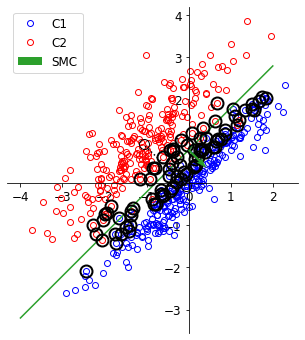

In [271]:
plot_clasi(x, t, [w_smc[1:],], ['SMC', ], xp=[-4, 2], thr=[-w_smc[0],])

plt.plot(x[0, isv], x[1, isv], 'o', ms=12, mfc='None', mec='k', mew=2)